In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import accuracy_score, brier_score_loss

%matplotlib inline

from collections import Counter
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

In [4]:
!ls tmp

iteration100.png iteration250.png iteration400.png
iteration150.png iteration300.png iteration450.png
iteration200.png iteration350.png iteration50.png


In [9]:
dataset = pd.read_csv("adult.csv")
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [10]:
dataset.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [11]:
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


<AxesSubplot:>

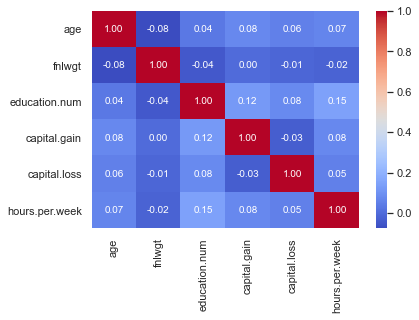

In [12]:
numeric_features = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week','income']
cat_features = ['workclass','education','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native']
    
sns.heatmap(dataset[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [14]:
dataset

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


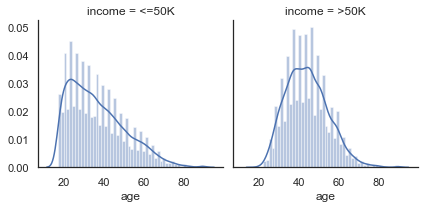

In [13]:
g = sns.FacetGrid(dataset, col='income')
g.map(sns.distplot, "age")

In [15]:
def clean_dataset(df):
    df['income']=df['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
    df["workclass"] = df["workclass"].fillna("X")
    df["occupation"] = df["occupation"].fillna("X")
    df["native.country"] = df["native.country"].fillna("United-States")
    df["sex"] = df["sex"].map({"Male": 0, "Female":1})
    df["marital.status"] = df["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
    df["marital.status"] = df["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
    df["marital.status"] = df["marital.status"].map({"Married":1, "Single":0})
    df["marital.status"] = df["marital.status"].astype(int)
    df.drop(labels=["workclass","education","occupation","relationship","race","native.country"], axis = 1, inplace = True)
    return df

In [16]:
dataset = clean_dataset(dataset)
dataset.tail()

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
32556,22,310152,10,0,0,0,0,40,0
32557,27,257302,12,1,1,0,0,38,0
32558,40,154374,9,1,0,0,0,40,1
32559,58,151910,9,0,1,0,0,40,0
32560,22,201490,9,0,0,0,0,20,0


In [17]:
array = dataset.values
X = array[:,0:8]
Y = array[:,8]
validation_size = 0.20
seed = 7
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,
    test_size=validation_size,random_state=seed)

In [18]:
def plot_calibration_curve(array_probas, array_true_label, num_bins=5):

    ## Prepare Array
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    bined_plot = df_probas.groupby('bins').mean()

    ## Calculate Brier Score
    brier_plot = brier_score_loss(array_true_label, array_probas)
    
    ## Calculate ECE
    ece, _ = calculate_ece(array_probas, array_true_label, num_bins)
    
    ## Plot Calibration Curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(bined_plot['probas'], bined_plot['label'], "s-", label="Reliability Plot")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Calibration plots  (reliability curve)')
    
    bbox_props = dict(boxstyle="round", fc="lightgrey", ec="brown", lw=2)
    ax1.text(0.1, 0.9, "Brier Score: {:.4f}".format(brier_plot), ha="center", va="center", size=14, weight = 'bold', bbox=bbox_props)
    ax1.text(0.1, 0.8, "ECE: {:.4f}".format(ece), ha="center", va="center", size=14, weight = 'bold', bbox=bbox_props)

    ax2.hist(df_probas['probas'], range=(0, 1), bins=num_bins, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax1.grid()
    ax2.grid()
    plt.tight_layout()
    plt.show()

In [19]:
def plot_compare_calibration(array_probas, array_probas_calibrated, array_true_label, num_bins=5):

    ## Prepare Array
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    array_probas_calibrated =(array_probas_calibrated - array_probas_calibrated.min()) / (array_probas_calibrated.max() - array_probas_calibrated.min())
    
    df_probas = pd.DataFrame({'probas': array_probas, 
                              'calibrated':array_probas_calibrated,
                              'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    bined_plot = df_probas.groupby('bins').mean()

    ## Calculate Brier Score
    brier_plot_prior = brier_score_loss(array_true_label, array_probas)
    brier_plot_calib = brier_score_loss(array_true_label, array_probas_calibrated)
    
    ## Calculate ECE
    ece_prior, _ = calculate_ece(array_probas, array_true_label, num_bins)
    ece_calib, _ = calculate_ece(array_probas_calibrated, array_true_label, num_bins)
    
    ## Plot Calibration Curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(bined_plot['probas'], bined_plot['label'], color='green', linestyle='dashed', label="Reliability Plot")
    ax1.plot(bined_plot['calibrated'], bined_plot['label'], color='orange', linestyle='solid', label="Reliability Plot")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Calibration plots  (reliability curve)')
    
    ax1.text(0.1, 0.9, "Brier Score: {:.4f}".format(brier_plot_prior), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'green', 'lw': 2})
    ax1.text(0.1, 0.8, "ECE Score: {:.4f}".format(ece_prior), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'green', 'lw': 2})
    ax1.text(0.1, 0.7, "Brier Score Calibrated: {:.4f}".format(brier_plot_calib), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'orange', 'lw': 2})
    ax1.text(0.1, 0.6, "ECE Calibrated: {:.4f}".format(ece_calib), size=14, bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'orange', 'lw': 2})

    ax1.grid()
    plt.tight_layout()
    plt.show()

## Models

In [20]:
rf = RandomForestClassifier(n_estimators=10,max_features=5)
rf.fit(X_train, Y_train)
preds_proba_rf = rf.predict_proba(X_validation)
preds_rf = rf.predict(X_validation)
accuracy_score(Y_validation, preds_rf)

0.837095040687855

In [21]:
ab = AdaBoostClassifier(n_estimators=10)
ab.fit(X_train, Y_train)
preds_proba_ab = ab.predict_proba(X_validation)
preds_ab = ab.predict(X_validation)
accuracy_score(Y_validation, preds_ab)

0.8432366037156457

In [22]:
hidden_size = 100
nn=MLPClassifier(hidden_layer_sizes=(hidden_size, ), 
                 activation='logistic', 
                 solver='sgd')
nn.fit(X_train, Y_train)
preds_proba_nn = nn.predict_proba(X_validation)
preds_nn = nn.predict(X_validation)
accuracy_score(Y_validation, preds_nn)

0.7621679717488101

## Expected Calibration Error

**Expected Calibration Error** $\rightarrow$ partition prediction into *M* bins, and take weighted average of the bins accuracy/confidence difference:


$$
\mathbb{E}_{\hat{P}}[| \mathbb{P}(\hat{Y}=Y \;|\;\hat{P}=P) -\textit{p} |]
$$

$$
ECE = \sum_{m=1}^{M} \frac{|B_{m}|}{n} |acc(B_{m})-conf(B_{m})|
$$


## Maximum Calibration Error (for High Risk applications)

**Maximum Calibration Error** $\rightarrow$ we may wish to minimize the worst-case
deviation between confidence and accuracy:

$$
max_{p\in[0,1]} \;| \mathbb{P}(\hat{Y}=Y \;|\;\hat{P}=P) -\textit{p} |
$$

$$
MCE = max_{m\in\{1,...,M\}} \;|acc(B_{m})-conf(B_{m})|
$$

In [23]:
def calculate_ece(array_probas, array_true_label, num_bins=10):
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    df_probas['bins_count']=df_probas['bins']
    bined_plot = df_probas.groupby('bins')\
        .agg({'probas':'mean', 'label':'mean', 'bins_count':'size'})\
        .rename(columns={'bins_count':'count'})\
        .reset_index()
    ece = ((bined_plot['probas']-bined_plot['label']).abs()/bined_plot['count']).sum()
    return ece, bined_plot

In [24]:
def calculate_mce(array_probas, array_true_label, num_bins=10):
    array_probas=(array_probas - array_probas.min()) / (array_probas.max() - array_probas.min())
    df_probas = pd.DataFrame({'probas': array_probas, 'label': array_true_label})
    df_probas['bins'] = pd.cut(df_probas.probas, num_bins, labels=np.arange(num_bins))
    df_probas['bins_count']=df_probas['bins']
    bined_plot = df_probas.groupby('bins')\
        .agg({'probas':'mean', 'label':'mean', 'bins_count':'size'})\
        .rename(columns={'bins_count':'count'})\
        .reset_index()
    mce = (bined_plot['probas']-bined_plot['label']).abs().max()
    return mce, bined_plot

In [25]:
calculate_ece(preds_proba_rf[:,1], Y_validation)

(0.004192043767524118,   bins    probas     label  count
 0    0  0.018501  0.060543   3865
 1    1  0.199696  0.236515    482
 2    2  0.299544  0.295393    369
 3    3  0.399618  0.381944    288
 4    4  0.498660  0.435294    255
 5    5  0.599775  0.481982    222
 6    6  0.699468  0.489362    235
 7    7  0.800000  0.591160    181
 8    8  0.900000  0.722892    166
 9    9  1.000000  0.937778    450)

In [26]:
calculate_mce(preds_proba_rf[:,1], Y_validation)

(0.21010638297872258,   bins    probas     label  count
 0    0  0.018501  0.060543   3865
 1    1  0.199696  0.236515    482
 2    2  0.299544  0.295393    369
 3    3  0.399618  0.381944    288
 4    4  0.498660  0.435294    255
 5    5  0.599775  0.481982    222
 6    6  0.699468  0.489362    235
 7    7  0.800000  0.591160    181
 8    8  0.900000  0.722892    166
 9    9  1.000000  0.937778    450)

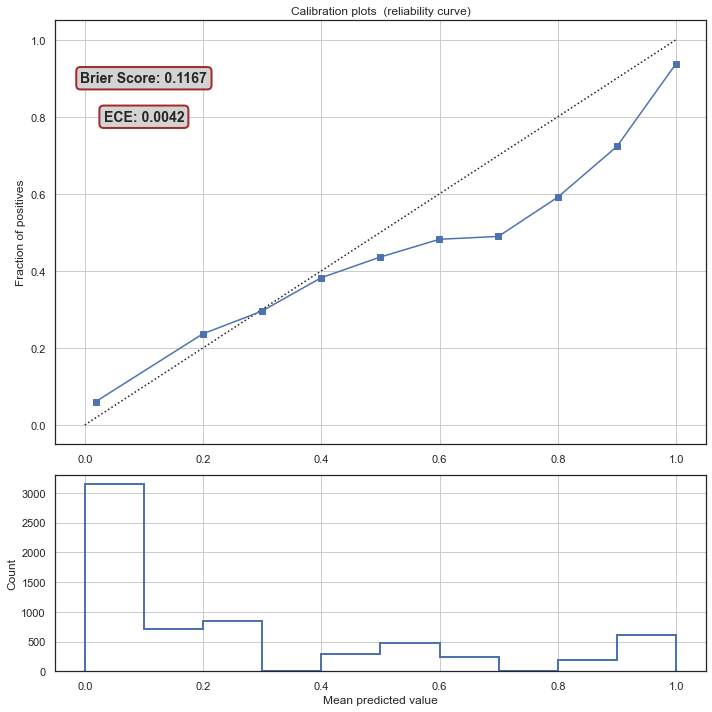

In [27]:
plot_calibration_curve(preds_proba_rf[:,1], 
                        Y_validation, 
                        num_bins=10)

In [28]:
calculate_ece(preds_proba_ab[:,1], Y_validation)

(0.00397863362894993,   bins    probas     label  count
 0    0  0.060143  0.001890    529
 1    1  0.157679  0.003125    640
 2    2  0.249919  0.018764    906
 3    3  0.341423  0.076240   1351
 4    4  0.443340  0.204469    895
 5    5  0.529537  0.396648   1253
 6    6  0.638180  0.682709    561
 7    7  0.751189  0.865169     89
 8    8  0.834455  0.983607    122
 9    9  0.957265  0.994012    167)

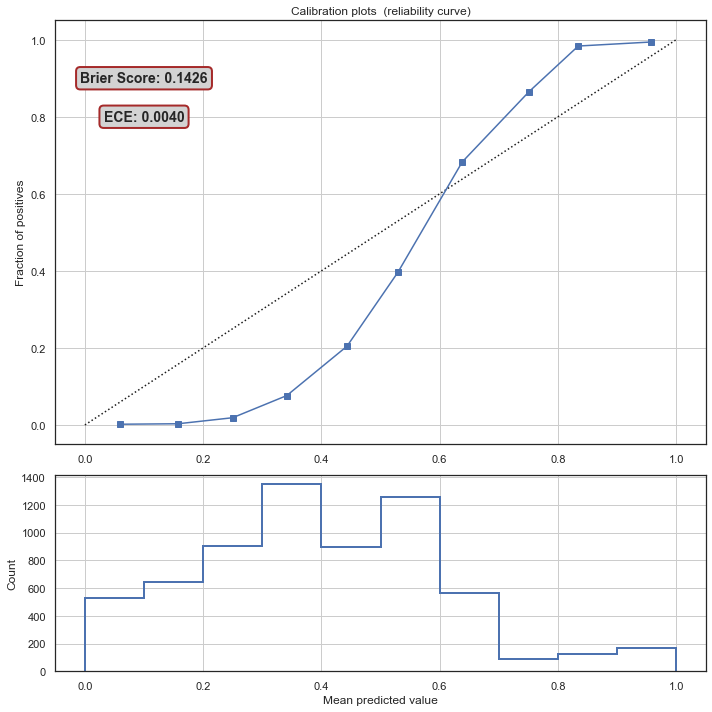

In [29]:
plot_calibration_curve(preds_proba_ab[:,1], 
                        Y_validation, 
                        num_bins=10)

In [30]:
calculate_ece(preds_proba_nn[:,1], Y_validation)

(1.0185910472724446,   bins        probas     label  count
 0    0  5.947941e-11  0.233395   6474
 1    1           NaN       NaN      0
 2    2  2.595636e-01  1.000000      1
 3    3           NaN       NaN      0
 4    4  4.123471e-01  0.666667      3
 5    5  5.821792e-01  1.000000     10
 6    6  6.927622e-01  1.000000      8
 7    7  7.551607e-01  1.000000      8
 8    8  8.426925e-01  1.000000      2
 9    9  9.727001e-01  1.000000      7)

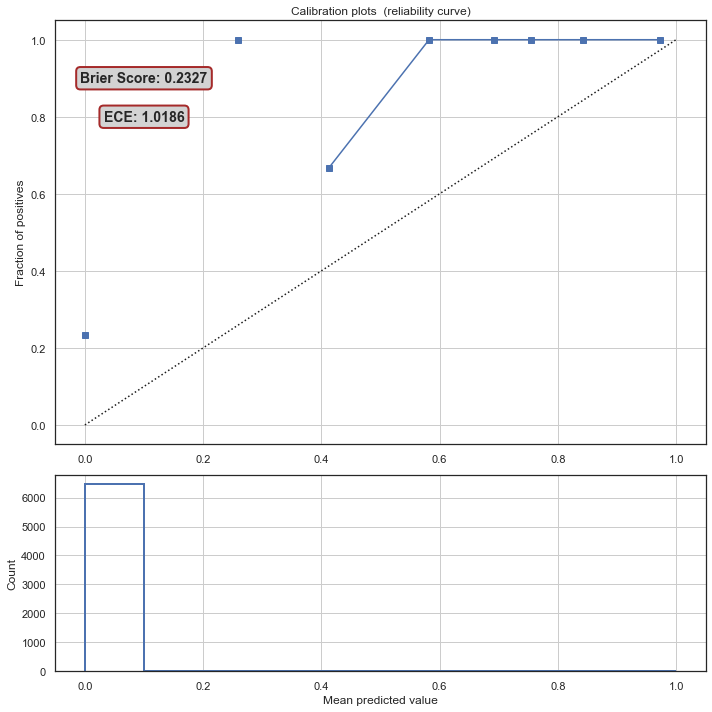

In [31]:
plot_calibration_curve(preds_proba_nn[:,1], 
                        Y_validation, 
                        num_bins=10)

## Isotonic Regression to Calibrate Preds

In [32]:
def generate_calibrated_isotonic(uncalibrated_preds, true_label):
    xtrain = uncalibrated_preds
    ytrain = true_label
    
    ## Calibrate Models
    isotonic_model = IsotonicRegression()
    isotonic_model.fit(xtrain,ytrain)
    
    calibrated_preds = isotonic_model.predict(uncalibrated_preds)

    return calibrated_preds

In [33]:
calibrated_probs_rf = generate_calibrated_isotonic(preds_proba_rf[:,1], Y_validation)
calibrated_probs_rf

array([0.03808315, 0.03808315, 0.29589041, ..., 0.03808315, 0.48198198,
       0.93777778])

#### Calibrate Random Forest w/ Isotonic Regression

In [34]:
from sklearn.calibration import CalibratedClassifierCV

In [35]:
## Random Forest w/ Plat Scalling
clf_rf_platt = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
clf_rf_platt.fit(X_train, Y_train)
prob_rf_platt = clf_rf_platt.predict_proba(X_validation)[:, 1]
prob_rf_platt

array([0.06540936, 0.06540936, 0.18502374, ..., 0.08267133, 0.47979222,
       0.88017446])

In [36]:
calculate_mce(preds_proba_rf[:,1],Y_validation), calculate_mce(prob_rf_platt,Y_validation)

((0.21010638297872258,   bins    probas     label  count
  0    0  0.018501  0.060543   3865
  1    1  0.199696  0.236515    482
  2    2  0.299544  0.295393    369
  3    3  0.399618  0.381944    288
  4    4  0.498660  0.435294    255
  5    5  0.599775  0.481982    222
  6    6  0.699468  0.489362    235
  7    7  0.800000  0.591160    181
  8    8  0.900000  0.722892    166
  9    9  1.000000  0.937778    450),
 (0.1547573893529005,   bins    probas     label  count
  0    0  0.015277  0.054096   3845
  1    1  0.144090  0.199161    477
  2    2  0.237929  0.336683    398
  3    3  0.343211  0.344538    357
  4    4  0.440147  0.480315    254
  5    5  0.542680  0.564748    278
  6    6  0.642522  0.529412    136
  7    7  0.743329  0.588571    175
  8    8  0.850913  0.786260    131
  9    9  0.982723  0.935065    462))

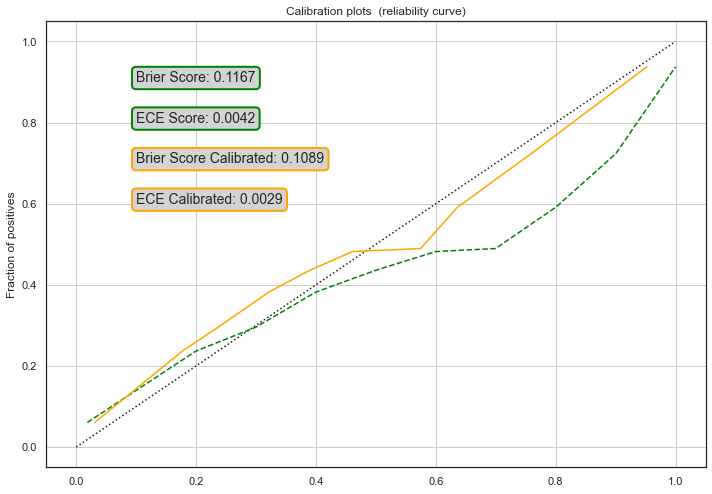

In [37]:
plot_compare_calibration(preds_proba_rf[:,1],
                         prob_rf_platt,
                         Y_validation,
                         num_bins=10)

In [38]:
## Random Forest w/ Isotonic Regression
clf_rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
clf_rf_isotonic.fit(X_train, Y_train)
prob_rf_isotonic = clf_rf_isotonic.predict_proba(X_validation)[:, 1]
prob_rf_isotonic

array([0.03747522, 0.03747522, 0.25684538, ..., 0.03747522, 0.49965215,
       0.93446958])

In [39]:
calculate_mce(preds_proba_rf[:,1],Y_validation), calculate_mce(prob_rf_isotonic,Y_validation)

((0.21010638297872258,   bins    probas     label  count
  0    0  0.018501  0.060543   3865
  1    1  0.199696  0.236515    482
  2    2  0.299544  0.295393    369
  3    3  0.399618  0.381944    288
  4    4  0.498660  0.435294    255
  5    5  0.599775  0.481982    222
  6    6  0.699468  0.489362    235
  7    7  0.800000  0.591160    181
  8    8  0.900000  0.722892    166
  9    9  1.000000  0.937778    450),
 (0.07009421967265095,   bins    probas     label  count
  0    0  0.013178  0.030622   3135
  1    1  0.142565  0.157962    785
  2    2  0.249381  0.242658    647
  3    3  0.349223  0.386640    494
  4    4  0.441741  0.457746    426
  5    5  0.541645  0.561265    253
  6    6  0.640775  0.570681    191
  7    7  0.758641  0.776224    143
  8    8  0.858105  0.886076     79
  9    9  0.989537  0.983333    360))

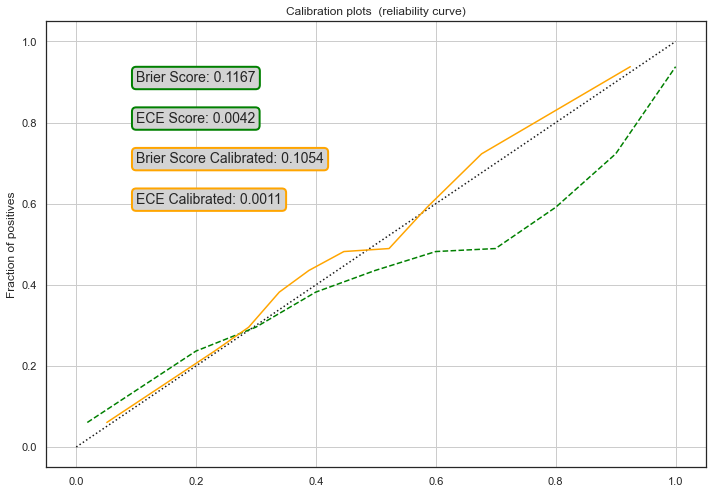

In [40]:
plot_compare_calibration(preds_proba_rf[:,1],
                         prob_rf_isotonic,
                         Y_validation,
                         num_bins=10)

In [41]:
## AdaBoost w/ Plat Scalling
clf_ab_platt = CalibratedClassifierCV(ab, cv=2, method='sigmoid')
clf_ab_platt.fit(X_train, Y_train)
prob_ab_platt = clf_ab_platt.predict_proba(X_validation)[:, 1]
prob_ab_platt

array([0.00618094, 0.01208472, 0.16576455, ..., 0.07412375, 0.33901674,
       0.99357858])

In [42]:
calculate_mce(preds_proba_ab[:,1],Y_validation), calculate_mce(prob_ab_platt,Y_validation)

((0.2651827363399471,   bins    probas     label  count
  0    0  0.060143  0.001890    529
  1    1  0.157679  0.003125    640
  2    2  0.249919  0.018764    906
  3    3  0.341423  0.076240   1351
  4    4  0.443340  0.204469    895
  5    5  0.529537  0.396648   1253
  6    6  0.638180  0.682709    561
  7    7  0.751189  0.865169     89
  8    8  0.834455  0.983607    122
  9    9  0.957265  0.994012    167),
 (0.14139567508602902,   bins    probas     label  count
  0    0  0.031269  0.028314   3214
  1    1  0.154036  0.170909    825
  2    2  0.248488  0.269912    226
  3    3  0.336621  0.334232    742
  4    4  0.470649  0.448473    524
  5    5  0.572890  0.714286     70
  6    6  0.641115  0.673307    251
  7    7  0.761810  0.669145    269
  8    8  0.850941  0.777778     54
  9    9  0.972922  0.982249    338))

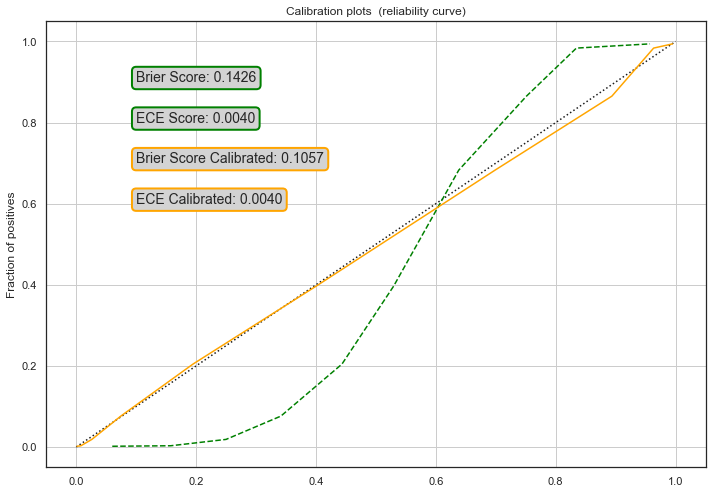

In [43]:
plot_compare_calibration(preds_proba_ab[:,1],
                         prob_ab_platt,
                         Y_validation,
                         num_bins=10)

In [44]:
## AdaBoost w/ Isotonic Regression
clf_ab_isotonic = CalibratedClassifierCV(ab, cv=2, method='isotonic')
clf_ab_isotonic.fit(X_train, Y_train)
prob_ab_isotonic = clf_ab_isotonic.predict_proba(X_validation)[:, 1]
prob_ab_isotonic

array([0.00268199, 0.00566857, 0.1702144 , ..., 0.11857375, 0.36642495,
       0.99392399])

In [45]:
calculate_mce(preds_proba_ab[:,1],Y_validation), calculate_mce(prob_ab_isotonic,Y_validation)

((0.2651827363399471,   bins    probas     label  count
  0    0  0.060143  0.001890    529
  1    1  0.157679  0.003125    640
  2    2  0.249919  0.018764    906
  3    3  0.341423  0.076240   1351
  4    4  0.443340  0.204469    895
  5    5  0.529537  0.396648   1253
  6    6  0.638180  0.682709    561
  7    7  0.751189  0.865169     89
  8    8  0.834455  0.983607    122
  9    9  0.957265  0.994012    167),
 (0.09139821442846541,   bins    probas     label  count
  0    0  0.026577  0.027371   3142
  1    1  0.155742  0.162073    907
  2    2  0.271430  0.231884    276
  3    3  0.365042  0.353870    633
  4    4  0.441806  0.445230    566
  5    5  0.561510  0.609375     64
  6    6  0.642610  0.685897    312
  7    7  0.748439  0.674208    221
  8    8  0.866908  0.775510     49
  9    9  0.982623  0.979592    343))

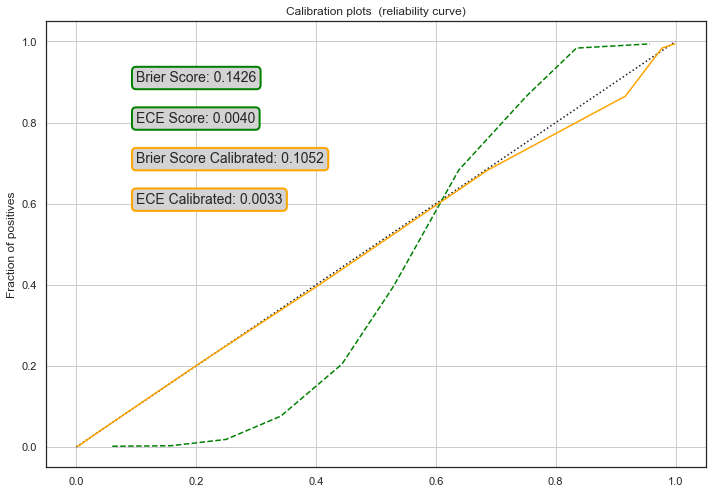

In [46]:
plot_compare_calibration(preds_proba_ab[:,1],
                         prob_ab_isotonic,
                         Y_validation,
                         num_bins=10)

In [47]:
## NN w/ Plat Scalling
clf_nn_platt = CalibratedClassifierCV(nn, cv=2, method='sigmoid')
clf_nn_platt.fit(X_train, Y_train)
prob_nn_platt = clf_nn_platt.predict_proba(X_validation)[:, 1]
prob_nn_platt

array([0.23623581, 0.23623581, 0.23623581, ..., 0.23623581, 0.23623581,
       0.23623581])

In [48]:
calculate_mce(preds_proba_nn[:,1],Y_validation), calculate_mce(prob_nn_platt,Y_validation)

((0.7404364038235036,   bins        probas     label  count
  0    0  5.947941e-11  0.233395   6474
  1    1           NaN       NaN      0
  2    2  2.595636e-01  1.000000      1
  3    3           NaN       NaN      0
  4    4  4.123471e-01  0.666667      3
  5    5  5.821792e-01  1.000000     10
  6    6  6.927622e-01  1.000000      8
  7    7  7.551607e-01  1.000000      8
  8    8  8.426925e-01  1.000000      2
  9    9  9.727001e-01  1.000000      7),
 (0.6270720028595469,   bins        probas     label  count
  0    0  7.156325e-07  0.232007   6461
  1    1           NaN       NaN      0
  2    2  2.326548e-01  0.833333      6
  3    3  3.729280e-01  1.000000      1
  4    4  4.688745e-01  1.000000      3
  5    5           NaN       NaN      0
  6    6           NaN       NaN      0
  7    7  7.440310e-01  1.000000      3
  8    8           NaN       NaN      0
  9    9  9.838471e-01  0.974359     39))

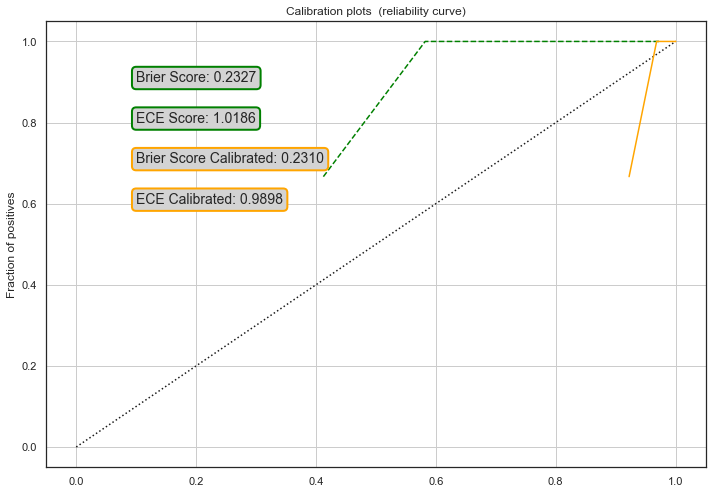

In [49]:
plot_compare_calibration(preds_proba_nn[:,1],
                         prob_nn_platt,
                         Y_validation,
                         num_bins=10)

In [50]:
## NN w/ Isotonic Regression
clf_nn_isotonic = CalibratedClassifierCV(ab, cv=2, method='isotonic')
clf_nn_isotonic.fit(X_train, Y_train)
prob_nn_isotonic = clf_nn_isotonic.predict_proba(X_validation)[:, 1]
prob_nn_isotonic

array([0.00268199, 0.00566857, 0.1702144 , ..., 0.11857375, 0.36642495,
       0.99392399])

In [51]:
calculate_mce(preds_proba_nn[:,1],Y_validation), calculate_mce(prob_nn_isotonic,Y_validation)

((0.7404364038235036,   bins        probas     label  count
  0    0  5.947941e-11  0.233395   6474
  1    1           NaN       NaN      0
  2    2  2.595636e-01  1.000000      1
  3    3           NaN       NaN      0
  4    4  4.123471e-01  0.666667      3
  5    5  5.821792e-01  1.000000     10
  6    6  6.927622e-01  1.000000      8
  7    7  7.551607e-01  1.000000      8
  8    8  8.426925e-01  1.000000      2
  9    9  9.727001e-01  1.000000      7),
 (0.0913982144284643,   bins    probas     label  count
  0    0  0.026577  0.027371   3142
  1    1  0.155742  0.162073    907
  2    2  0.271430  0.231884    276
  3    3  0.365042  0.353870    633
  4    4  0.441806  0.445230    566
  5    5  0.561510  0.609375     64
  6    6  0.642610  0.685897    312
  7    7  0.748439  0.674208    221
  8    8  0.866908  0.775510     49
  9    9  0.982623  0.979592    343))

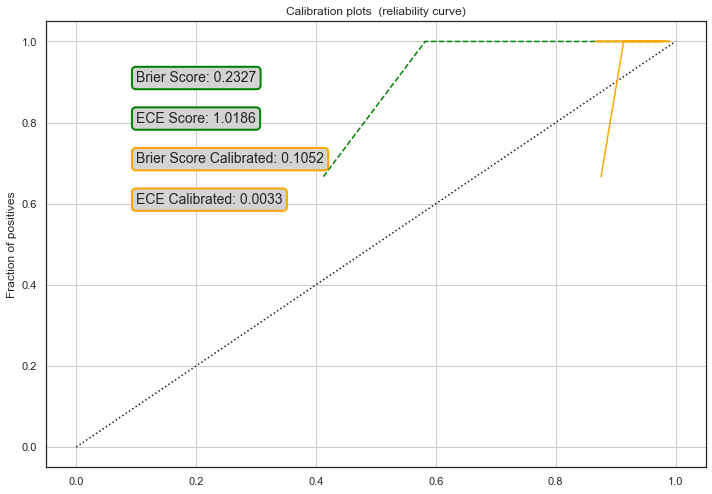

In [52]:
plot_compare_calibration(preds_proba_nn[:,1],
                         prob_nn_isotonic,
                         Y_validation,
                         num_bins=10)

### Sources
1. https://www.kaggle.com/ipbyrne/income-prediction-84-369-accuracym  
2. https://scikit-learn.org/stable/modules/calibration.html